In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import dask.dataframe as dd
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
def download_and_extract():
    api = KaggleApi()

    dataset_path = 'meowmeowmeowmeowmeow/gtsrb-german-traffic-sign'
    output_path = './gtsrb_data'
    os.makedirs(output_path, exist_ok=True)

    api.dataset_download_files(dataset_path, path=output_path, unzip=True)
    print(f'Dataset pobrany i rozpakowany w: {output_path}')

download_and_extract()

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
Dataset pobrany i rozpakowany w: ./gtsrb_data


In [4]:
def load_and_prepare_data(data_dir, data_fraction=1.0, num_classes=None):
    train_csv_path = os.path.join(data_dir, 'Train.csv')
    test_csv_path = os.path.join(data_dir, 'Test.csv')

    train_df = dd.read_csv(train_csv_path).compute()
    test_df = dd.read_csv(test_csv_path).compute()

    if num_classes:
        selected_classes = sorted(train_df['ClassId'].unique())[:num_classes]
        train_df = train_df[train_df['ClassId'].isin(selected_classes)]
        test_df = test_df[test_df['ClassId'].isin(selected_classes)]

    if data_fraction < 1.0:
        train_df = train_df.sample(frac=data_fraction, random_state=42)

    train_data, val_data = train_test_split(train_df, test_size=0.3, random_state=42)

    print(f'Liczba próbek w zbiorze treningowym: {len(train_data)}')
    print(f'Liczba próbek w zbiorze walidacyjnym: {len(val_data)}')
    print(f'Liczba próbek w zbiorze testowym: {len(test_df)}')

    print('Podgląd danych treningowych:')
    print(train_data.head())
    print('Podgląd danych testowych:')
    print(test_df.head())

    return train_data, val_data, test_df

data_dir = './gtsrb_data'
train_data, val_data, test_data = load_and_prepare_data(data_dir, data_fraction=1.0, num_classes=None)

Liczba próbek w zbiorze treningowym: 27446
Liczba próbek w zbiorze walidacyjnym: 11763
Liczba próbek w zbiorze testowym: 12630
Podgląd danych treningowych:
       Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
27138     52      49       5       6      47      44       21   
35509     47      48       5       6      42      43       36   
34873     45      44       6       6      40      39       35   
33317     75      81       6       8      69      74       33   
37958     30      31       5       6      25      26       38   

                                 Path  
27138  Train/21/00021_00005_00018.png  
35509  Train/36/00036_00003_00020.png  
34873  Train/35/00035_00022_00014.png  
33317  Train/33/00033_00007_00017.png  
37958  Train/38/00038_00065_00009.png  
Podgląd danych testowych:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      3

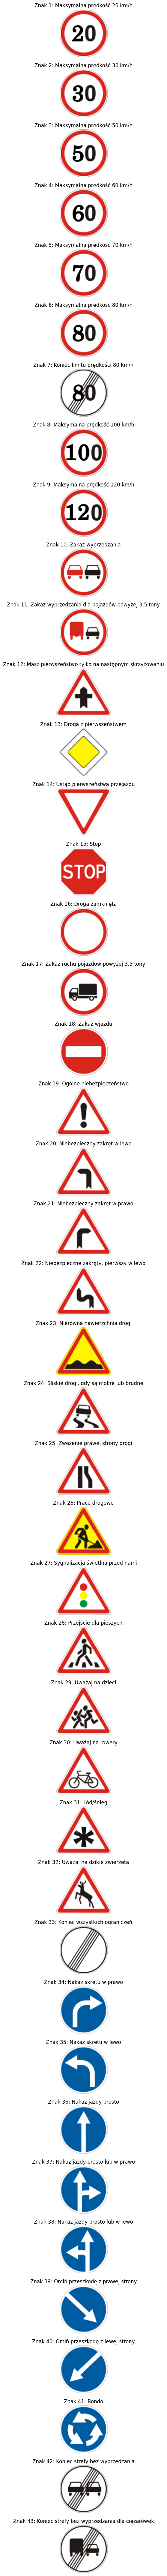

In [5]:
def show_all_possible_road_sign():
    path = './gtsrb_data/Meta'
    image_files = sorted([f for f in os.listdir(path) if f.endswith('.png')],
                        key=lambda s: int(re.search(r'\d+', s).group()))

    road_sign_name = {0: 'Maksymalna prędkość 20 km/h',
                      1: 'Maksymalna prędkość 30 km/h',
                      2: 'Maksymalna prędkość 50 km/h',
                      3: 'Maksymalna prędkość 60 km/h',
                      4: 'Maksymalna prędkość 70 km/h',
                      5: 'Maksymalna prędkość 80 km/h',
                      6: 'Koniec limitu prędkości 80 km/h',
                      7: 'Maksymalna prędkość 100 km/h',
                      8: 'Maksymalna prędkość 120 km/h',
                      9: 'Zakaz wyprzedzania',
                      10: 'Zakaz wyprzedzania dla pojazdów powyżej 3,5 tony',
                      11: 'Masz pierwszeństwo tylko na następnym skrzyżowaniu',
                      12: 'Droga z pierwszeństwem',
                      13: 'Ustąp pierwszeństwa przejazdu',
                      14: 'Stop',
                      15: 'Droga zamknięta',
                      16: 'Zakaz ruchu pojazdów powyżej 3,5 tony',
                      17: 'Zakaz wjazdu',
                      18: 'Ogólne niebezpieczeństwo',
                      19: 'Niebezpieczny zakręt w lewo',
                      20: 'Niebezpieczny zakręt w prawo',
                      21: 'Niebezpieczne zakręty, pierwszy w lewo',
                      22: 'Nierówna nawierzchnia drogi',
                      23: 'Śliskie drogi, gdy są mokre lub brudne',
                      24: 'Zwężenie prawej strony drogi',
                      25: 'Prace drogowe',
                      26: 'Sygnalizacja świetlna przed nami',
                      27: 'Przejście dla pieszych',
                      28: 'Uważaj na dzieci',
                      29: 'Uważaj na rowery',
                      30: 'Lód/śnieg',
                      31: 'Uważaj na dzikie zwierzęta',
                      32: 'Koniec wszystkich ograniczeń',
                      33: 'Nakaz skrętu w prawo',
                      34: 'Nakaz skrętu w lewo',
                      35: 'Nakaz jazdy prosto',
                      36: 'Nakaz jazdy prosto lub w prawo',
                      37: 'Nakaz jazdy prosto lub w lewo',
                      38: 'Omiń przeszkodę z prawej strony',
                      39: 'Omiń przeszkodę z lewej strony',
                      40: 'Rondo',
                      41: 'Koniec strefy bez wyprzedzania',
                      42: 'Koniec strefy bez wyprzedzania dla ciężarówek'}

    num_signs = len(image_files)
    fig, axes = plt.subplots(num_signs, 1, figsize=(10, num_signs * 2))

    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(path, img_file)
        image = Image.open(img_path)

        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(f'Znak {idx+1}: {road_sign_name[idx]}')

    plt.tight_layout()
    plt.show()

show_all_possible_road_sign()

Liczba klas: 6
Całkowita liczba próbek: 103764
   Class  Count
0   Meta     43
1   Test  12630
2  Train  39209
3   meta     43
4   test  12630
5  train  39209


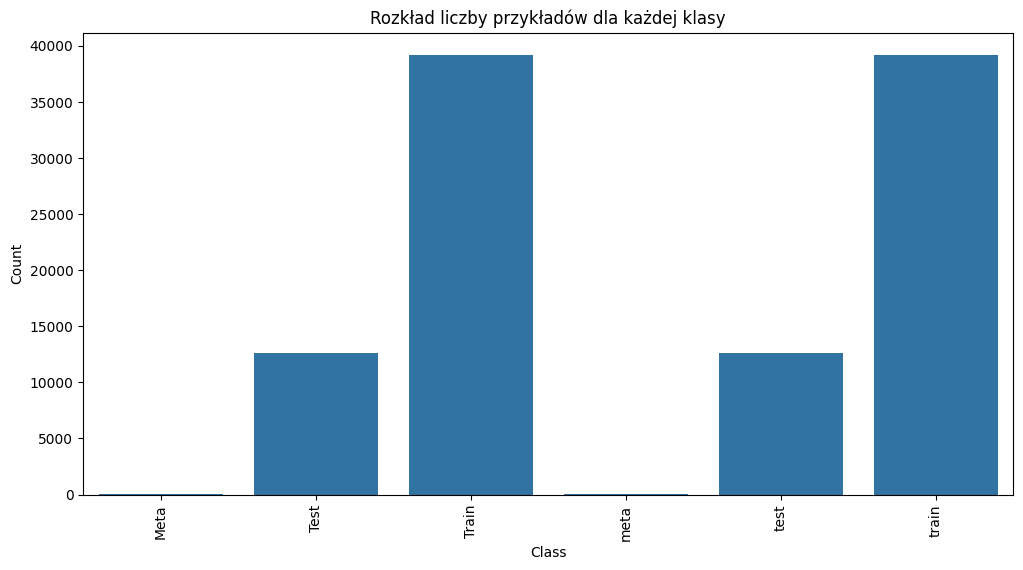

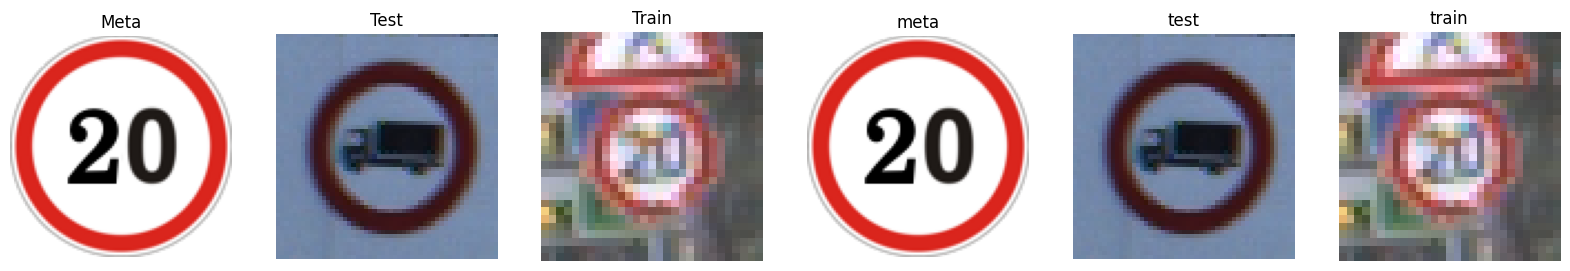

In [7]:
def explore_data(data_dir):
    dataset = datasets.ImageFolder(root=data_dir)
    class_names = dataset.classes
    class_counts = [0] * len(class_names)

    for _, label in dataset.samples:
        class_counts[label] += 1

    data_summary = pd.DataFrame({
        'Class': class_names,
        'Count': class_counts
    })

    print('Liczba klas:', len(class_names))
    print('Całkowita liczba próbek:', sum(class_counts))
    print(data_summary)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', data=data_summary)
    plt.xticks(rotation=90)
    plt.title('Rozkład liczby przykładów dla każdej klasy')
    plt.show()

    fig, axs = plt.subplots(1, len(class_names), figsize=(20, 5))
    for i, class_name in enumerate(class_names):
        class_samples = [sample for sample, label in dataset.samples if label == i]
        example_image = plt.imread(class_samples[0])
        axs[i].imshow(example_image)
        axs[i].set_title(class_name)
        axs[i].axis('off')
    plt.show()

data_dir = './gtsrb_data'
explore_data(data_dir)

In [8]:
class TrafficSignDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.data_dir, row['Path'])
        label = row['ClassId']

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = TrafficSignDataset(train_data, data_dir, transform=transform)
val_dataset = TrafficSignDataset(val_data, data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
class TrafficSignModel(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def train_model(train_data, val_data, test_data, data_dir, num_classes, epochs=10, batch_size=32, learning_rate=0.001):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = TrafficSignDataset(train_data, data_dir, transform=transform)
    val_dataset = TrafficSignDataset(val_data, data_dir, transform=transform)
    test_dataset = TrafficSignDataset(test_data, data_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = TrafficSignModel(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Trening
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Walidacja
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {100 * correct/total:.2f}%')

    # Testowanie modelu
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

    return model

model = train_model(train_data, val_data, test_data, data_dir, num_classes=43, epochs=10, batch_size=32, learning_rate=0.001)
torch.save(model, 'trained_model.pth')

Epoch 1/10, Loss: 1.4603, Val Loss: 0.3932, Val Acc: 87.54%
Epoch 2/10, Loss: 0.1963, Val Loss: 0.1265, Val Acc: 96.62%
Epoch 3/10, Loss: 0.0757, Val Loss: 0.0931, Val Acc: 97.55%
Epoch 4/10, Loss: 0.0418, Val Loss: 0.1028, Val Acc: 97.20%
Epoch 5/10, Loss: 0.0463, Val Loss: 0.0787, Val Acc: 97.79%
Epoch 6/10, Loss: 0.0347, Val Loss: 0.0643, Val Acc: 98.66%
Epoch 7/10, Loss: 0.0306, Val Loss: 0.0779, Val Acc: 98.06%
Epoch 8/10, Loss: 0.0219, Val Loss: 0.1092, Val Acc: 97.13%
Epoch 9/10, Loss: 0.0278, Val Loss: 0.1181, Val Acc: 96.81%
Epoch 10/10, Loss: 0.0220, Val Loss: 0.0616, Val Acc: 98.75%
Test Accuracy: 93.42%


<ipython-input-19-fdd004b899c1>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


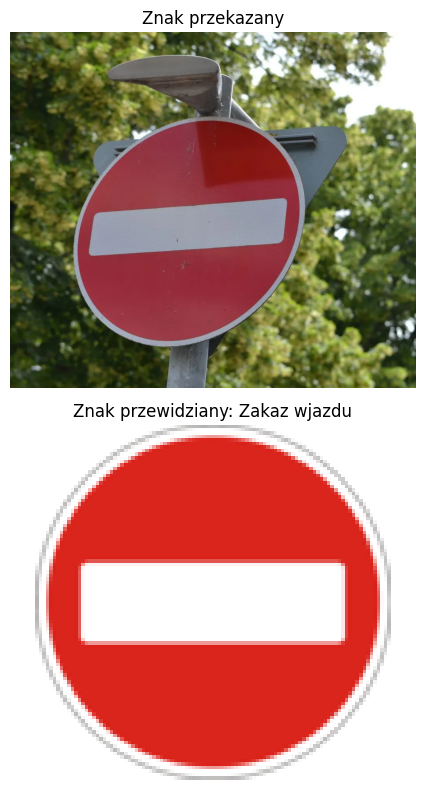

Przewidziany znak: Zakaz wjazdu


In [19]:
def predict_sign(model, image_path, transform, class_mapping):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(image)
        predicted_class_idx = output.argmax(dim=1).item()

    predicted_class_name = class_mapping[predicted_class_idx]

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    img_path_predicted = os.path.join('./gtsrb_data/Meta', str(predicted_class_idx)+'.png')
    image_predicted = Image.open(img_path_predicted)

    image_np = Image.open(image_path)

    axes[0].imshow(image_np)
    axes[0].axis('off')
    axes[0].set_title('Znak przekazany')

    axes[1].imshow(image_predicted)
    axes[1].axis('off')
    axes[1].set_title(f'Znak przewidziany: {predicted_class_name}')

    plt.tight_layout()
    plt.show()

    return predicted_class_name

road_sign_name = {0: 'Maksymalna prędkość 20 km/h',
                  1: 'Maksymalna prędkość 30 km/h',
                  2: 'Maksymalna prędkość 50 km/h',
                  3: 'Maksymalna prędkość 60 km/h',
                  4: 'Maksymalna prędkość 70 km/h',
                  5: 'Maksymalna prędkość 80 km/h',
                  6: 'Koniec limitu prędkości 80 km/h',
                  7: 'Maksymalna prędkość 100 km/h',
                  8: 'Maksymalna prędkość 120 km/h',
                  9: 'Zakaz wyprzedzania',
                  10: 'Zakaz wyprzedzania dla pojazdów powyżej 3,5 tony',
                  11: 'Masz pierwszeństwo tylko na następnym skrzyżowaniu',
                  12: 'Droga z pierwszeństwem',
                  13: 'Ustąp pierwszeństwa przejazdu',
                  14: 'Stop',
                  15: 'Droga zamknięta',
                  16: 'Zakaz ruchu pojazdów powyżej 3,5 tony',
                  17: 'Zakaz wjazdu',
                  18: 'Ogólne niebezpieczeństwo',
                  19: 'Niebezpieczny zakręt w lewo',
                  20: 'Niebezpieczny zakręt w prawo',
                  21: 'Niebezpieczne zakręty, pierwszy w lewo',
                  22: 'Nierówna nawierzchnia drogi',
                  23: 'Śliskie drogi, gdy są mokre lub brudne',
                  24: 'Zwężenie prawej strony drogi',
                  25: 'Prace drogowe',
                  26: 'Sygnalizacja świetlna przed nami',
                  27: 'Przejście dla pieszych',
                  28: 'Uważaj na dzieci',
                  29: 'Uważaj na rowery',
                  30: 'Lód/śnieg',
                  31: 'Uważaj na dzikie zwierzęta',
                  32: 'Koniec wszystkich ograniczeń',
                  33: 'Nakaz skrętu w prawo',
                  34: 'Nakaz skrętu w lewo',
                  35: 'Nakaz jazdy prosto',
                  36: 'Nakaz jazdy prosto lub w prawo',
                  37: 'Nakaz jazdy prosto lub w lewo',
                  38: 'Omiń przeszkodę z prawej strony',
                  39: 'Omiń przeszkodę z lewej strony',
                  40: 'Rondo',
                  41: 'Koniec strefy bez wyprzedzania',
                  42: 'Koniec strefy bez wyprzedzania dla ciężarówek'}

model_path = 'trained_model.pth'
model = torch.load(model_path)

test_image_path = './znak1.png'

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

predicted_sign = predict_sign(model, test_image_path, transform, road_sign_name)
print(f'Przewidziany znak: {predicted_sign}')